In [ ]:
from tensorflow.keras.applications import ResNet50

from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import torch
from custom_transformers import *
import tensorflow as tf
import matplotlib.pyplot as plt
from augmented_generator import *

## Load data

In [ ]:
cifar10 = tf.keras.datasets.cifar10

(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
print(f"X_train.shape: {X_train.shape} \nY_train.shape: {Y_train.shape} \nX_test.shape: {X_test.shape} \nY_test.shape: {Y_test.shape}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
X_train.shape: (50000, 32, 32, 3) 
Y_train.shape: (50000, 1) 
X_test.shape: (10000, 32, 32, 3) 
Y_test.shape: (10000, 1)


## Test Data Generator (with fraction 60% to visualize results)

Adding new samples

In [ ]:
polygon_cutout = PolygonCutout(max_vertices=12, min_vertices=3, max_size_ratio=0.4, color=None, random_color=True)
generator = AugmentedCIFAR10Generator(X_train, Y_train, batch_size=16, shuffle=True, augmentor= polygon_cutout, augment_fraction=0.2, overwrite=False)

batch_x, batch_y = generator[0]

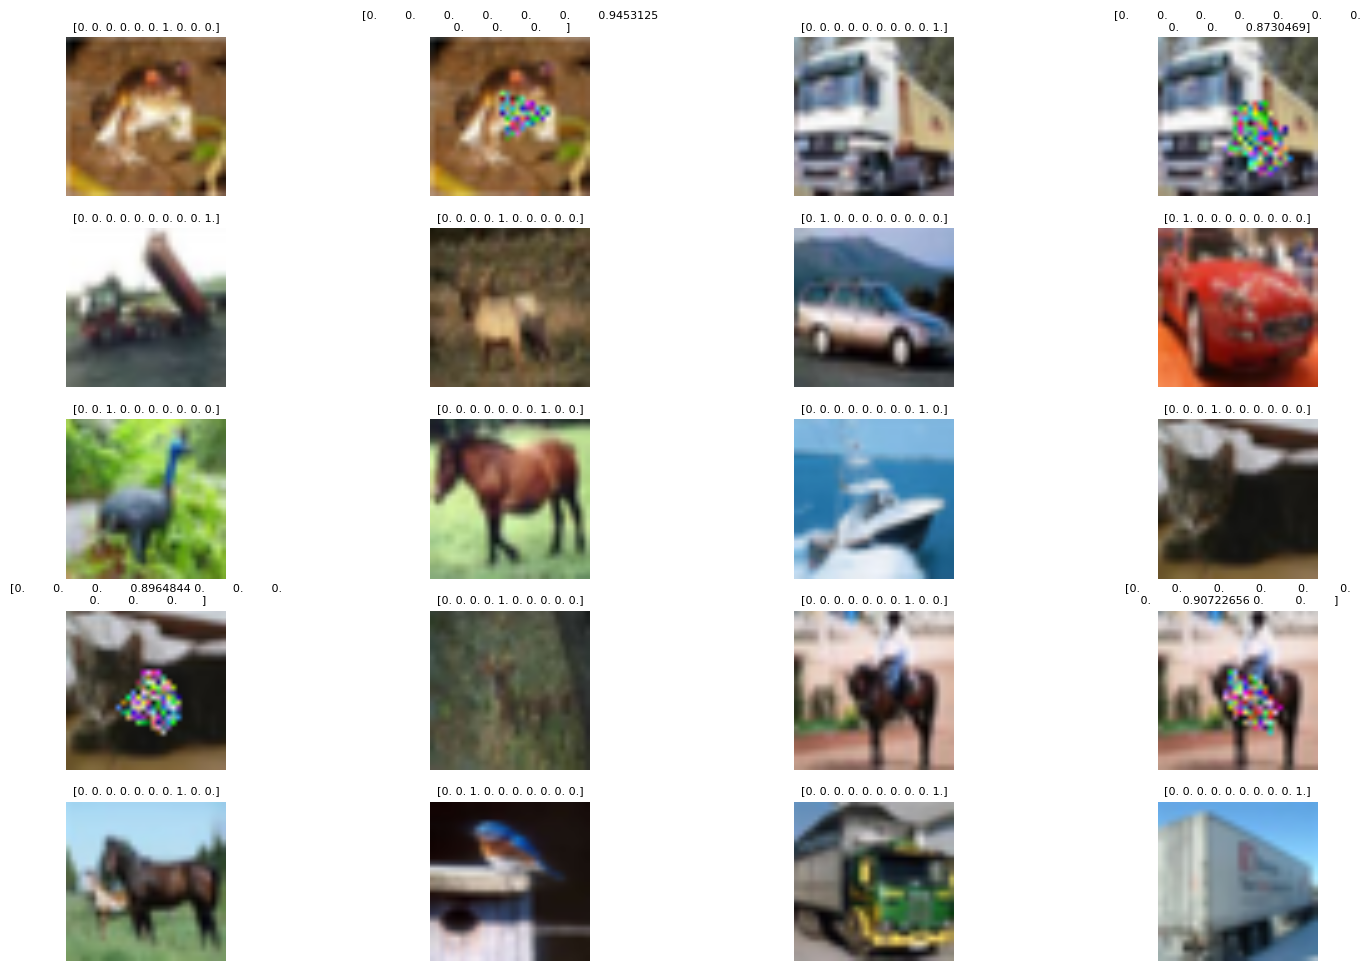

In [ ]:
#function to denormalize Restnet preprocessing for visualization purposes
def denormalize_resnet(x):
    x = x.copy()
    x[..., 0] += 103.939  # Blue
    x[..., 1] += 116.779  # Green
    x[..., 2] += 123.68   # Red
    # Zamiana BGR -> RGB
    x = x[..., ::-1]
    x = np.clip(x / 255.0, 0, 1)
    return x

n = len(batch_x)
cols = 4
rows = n//cols + int(n%cols != 0)

fig, axes = plt.subplots(rows, cols, figsize=(18, 12))
if rows == 1 or cols == 1:
    axes = np.expand_dims(axes, axis=0)
for i in range(len(batch_x)):
    row = i // cols
    col = i % cols
    ax = axes[row, col]
    ax.imshow(denormalize_resnet(batch_x[i]))
    ax.set_title(batch_y[i], fontsize=8)
    ax.axis('off')

As we can see some of the images are augmented with soft labels and added to the data and some have their original labels but with one hot encoding

With overwrite

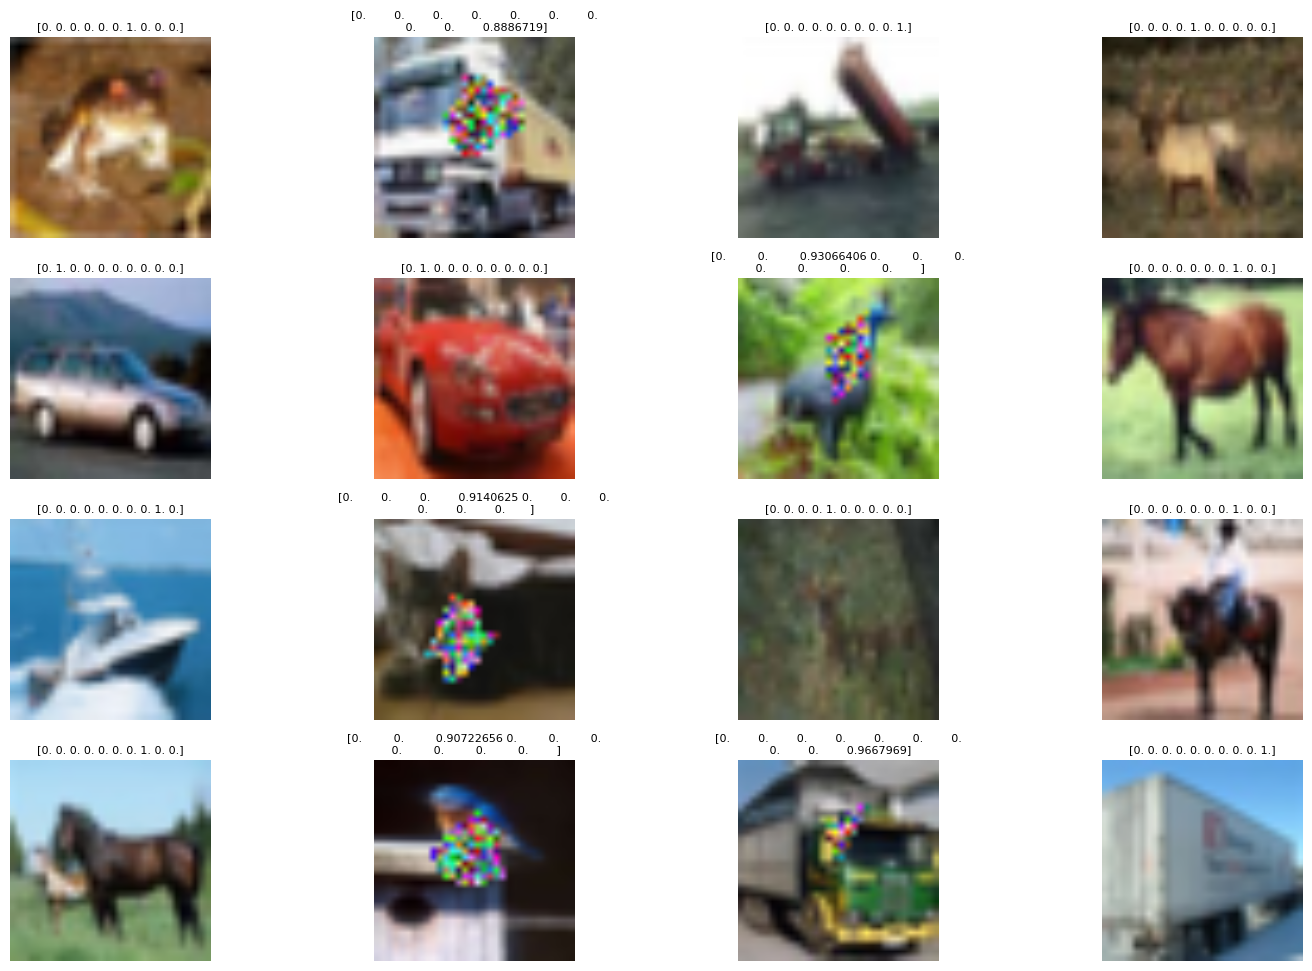

In [ ]:
polygon_cutout = PolygonCutout(max_vertices=12, min_vertices=3, max_size_ratio=0.4, color=None, random_color=True)
generator = AugmentedCIFAR10Generator(X_train, Y_train, batch_size=16, shuffle=True, augmentor= polygon_cutout, augment_fraction=0.2, overwrite=True)
batch_x, batch_y = generator[0]


n = len(batch_x)
cols = 4
rows = n//cols + int(n%cols != 0)

fig, axes = plt.subplots(rows, cols, figsize=(18, 12))
if rows == 1 or cols == 1:
    axes = np.expand_dims(axes, axis=0)
for i in range(len(batch_x)):
    row = i // cols
    col = i % cols
    ax = axes[row, col]
    ax.imshow(denormalize_resnet(batch_x[i]))
    ax.set_title(batch_y[i], fontsize=8)
    ax.axis('off')

## Restnet Training - Color Polygon

In [ ]:

polygon_cutout = PolygonCutout(max_vertices=12, min_vertices=3, max_size_ratio=0.4, color=None, random_color=True)


base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Create generators
train_gen = AugmentedCIFAR10Generator(
    X_train,
    Y_train,
    batch_size=16,
    augmentor=polygon_cutout,
    augment_fraction=0.2,
    overwrite=False
)

test_gen = AugmentedCIFAR10Generator(
    X_test,
    Y_test,
    batch_size=16,
    shuffle=False,  # No augmentation for test set
    augmentor=None
)


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # Works with both one-hot and soft labels
    metrics=['accuracy']
)

history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=5
)

Epoch 1/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 310s 96ms/step - accuracy: 0.7209 - loss: 0.9398 - val_accuracy: 0.7441 - val_loss: 3.4997
Epoch 2/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 255s 82ms/step - accuracy: 0.6995 - loss: 7.1269 - val_accuracy: 0.8094 - val_loss: 8.9139
Epoch 3/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 260s 83ms/step - accuracy: 0.6869 - loss: 25.4625 - val_accuracy: 0.8052 - val_loss: 22.6172
Epoch 4/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 262s 84ms/step - accuracy: 0.6890 - loss: 50.4882 - val_accuracy: 0.8271 - val_loss: 26.9460
Epoch 5/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 258s 83ms/step - accuracy: 0.6798 - loss: 87.0489 - val_accuracy: 0.8506 - val_loss: 29.8988


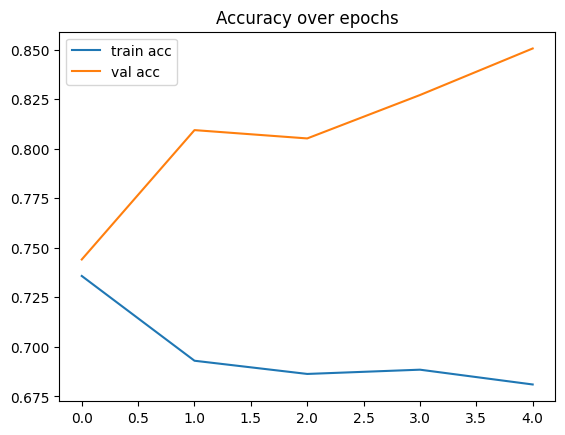

In [ ]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Accuracy over epochs")
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(test_gen)
print(f"Dokładność na zbiorze testowym: {test_acc:.2%}")


625/625 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.8507 - loss: 29.6609
Dokładność na zbiorze testowym: 85.06%


In [ ]:
model.save("polygon_cutout.keras")  # lub .keras


